In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, date, timedelta
# import openpyxl
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
!pip install XGBoost
import xgboost as xgb

  Using cached xgboost-1.0.2-py3-none-manylinux1_x86_64.whl (109.7 MB)


In [2]:
data = {}
xls = pd.read_excel("covid_final-5.xlsx", sheet_name = None)
for name, sheet in xls.items():
    if name == "12021.0":
        print("in")
        continue
    data[name] = sheet
    data[name] = data[name].dropna()
    data[name] = data[name].drop(columns=data[name].columns[:1])
    data[name] = data[name].drop(columns=["dates"])
#     data[name] = data[name].drop(columns=["Pacific_Islander"])
#     data[name] = data[name].drop(columns=["Other"])
#     data[name] = data[name].drop(columns=["cases-3"])
#     data[name] = data[name].drop(columns=["cases-4"])
#     data[name] = data[name].drop(columns=["cases-5"])
    data[name] = data[name].drop(columns=["cases-6"])
    data[name] = data[name].drop(columns=["cases-7"])
#     data[name] = data[name].drop(columns=["Social Mobility"])
    data[name] = data[name].drop(columns=["cases_lagged"])
    data[name] = data[name].drop(columns=["delta-1"])
#     data[name].insert(11, "days_since", [i*2 for i in range(len(data[name].index))])
    data[name].insert(11, "days_since", range(len(data[name].index)))
    data[name] = data[name].dropna()

in


In [3]:
big_data = pd.DataFrame(columns = data["36061.0"].columns)
for fips, df in data.items():
    big_data = big_data.append(df, ignore_index=True)
big_data.replace(-1, np.NaN)
print(len(big_data))
# ax = big_data.pop("axis")
labels = np.array(big_data.pop("delta"))
print(len(labels))
print(big_data.columns)

3478
3478
Index(['African_American', 'Pacific_Islander', 'Asian_American', 'Density',
       'Income_pc', 'Latino', 'M:F', 'Median_Age', 'Native_American', 'Other',
       ...
       'mobility-5', 'mobility-4', 'mobility-3', 'mobility-2', 'mobility-1',
       'cases-5', 'cases-4', 'cases-3', 'cases-2', 'cases-1'],
      dtype='object', length=106)


In [4]:
RSEED = 50
features = big_data.columns
train, test, train_labels, test_labels = train_test_split(big_data,
                                         labels,
                                         test_size = 0.65, 
                                         random_state = RSEED)
# train, test = train.drop(columns=["axis"]), test.drop(columns=["axis"])

In [38]:
model = RandomForestRegressor(n_estimators=1800,
                               max_depth=30,
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0, bootstrap=True)
# model = RandomForestRegressor(rf_random.best_params)
train = np.array(train).astype("float")
train_labels = np.array(train_labels).astype("int")
model.fit(train, train_labels)
rf_predictions_train = model.predict(train)
rf_predictions_test = model.predict(test)
fi_model = pd.DataFrame({'feature': list(big_data.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
print(fi_model.iloc[:25, :])

print(metrics.r2_score(np.array(train_labels).astype("int"), rf_predictions_train))
print(metrics.r2_score(np.array(test_labels).astype("int"), rf_predictions_test))
print(metrics.mean_squared_error(np.array(train_labels).astype("int"), rf_predictions_train))
print(metrics.mean_squared_error(np.array(test_labels).astype("int"), rf_predictions_test))
print(metrics.mean_absolute_error(np.array(train_labels).astype("int"), rf_predictions_train))
print(metrics.mean_absolute_error(np.array(test_labels).astype("int"), rf_predictions_test))

              feature  importance
105           cases-1    0.121904
103           cases-3    0.109825
104           cases-2    0.109323
102           cases-4    0.095954
101           cases-5    0.077758
4           Income_pc    0.070089
3             Density    0.067899
6                 M:F    0.046975
9               Other    0.018175
0    African_American    0.014955
1    Pacific_Islander    0.013896
16    Social Mobility    0.013831
95         mobility-6    0.013128
99         mobility-2    0.012097
96         mobility-5    0.011396
97         mobility-4    0.011268
100        mobility-1    0.011147
93         mobility-8    0.010655
98         mobility-3    0.010239
94         mobility-7    0.009776
80        mobility-21    0.008825
92         mobility-9    0.007989
10         Population    0.007438
5              Latino    0.007338
91        mobility-10    0.006839
0.9945012429529309
0.9632764473319604
1606.2573486614456
5416.225657153833
14.483131344750081
29.07726008298056


Text(0.5, 1.0, 'Feature Importances (RF2)')

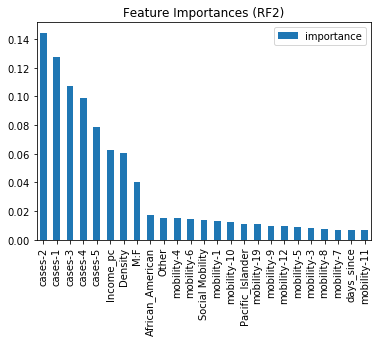

In [41]:
index = list(fi_opt1["feature"].iloc[:25])
# f = fi_model.iloc[:25, :]
f = fi_opt1.iloc[:25, :]
f.index = index
f.plot.bar()
# plt.title("Feature Importances (Model1)")
# plt.savefig("feat_imp0.png")
plt.title("Feature Importances (RF2)")
# plt.savefig("feat_imp3.png")

In [102]:
from sklearn.model_selection import learning_curve
size = len(big_data)
print(size)
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model,
    X = big_data,
    y = labels,
    train_sizes = [1, 100, 500, 1000, 1500, 2500],
    cv=5,
    scoring = 'neg_mean_squared_error'
)

3478


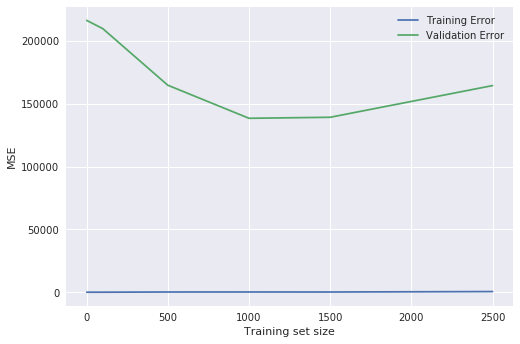

In [103]:
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
plt.style.use("seaborn")
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label="Training Error")
# ax1 = ax.twinx()
ax.plot(train_sizes, validation_scores_mean, label="Validation Error")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()

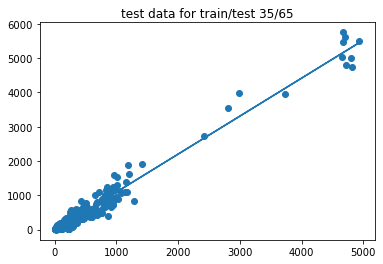

In [20]:
# m, b = np.polyfit(rf_predictions_test, test_labels, 1)
# # m1, b1, = np.polyfit(opt_predictions_test, test_labels, 1)
# fig, ax = plt.subplots()
# ax.scatter(rf_predictions_test, test_labels)
# # ax.scatter(opt_predictions_test, test_labels, color="r")
# # ax.plot(opt_predictions_test, opt_predictions_test*m1+b1, color="r")
# ax.plot(rf_predictions_test, rf_predictions_test*m+b)
# plt.title("test data for train/test 35/65")
# plt.savefig("0_std")

Notes:
- attempt with every other day dropped: 
    - RMSE before: test/train 0.9520921244737234 / 0.7161535868449757
    - RMSE after some cross-validation: 0.9542521782022533 / 0.8023325283549912
- attempt without:
    - RMSE without x/val: 0.9662764657845625 / 0.8953592377868811

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [12]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 39.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [40]:
opt1 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
# opt1 = rf_random.best_estimator_
# print(opt1)
train = np.array(train).astype("float")
train_labels = np.array(train_labels).astype("int")
opt1.fit(train, train_labels)
opt1_predictions_train = opt1.predict(train)
opt1_predictions_test = opt1.predict(test)

print(metrics.r2_score(np.array(train_labels).astype("int"), opt1_predictions_train))
print(metrics.r2_score(np.array(test_labels).astype("int"), opt1_predictions_test))
print(metrics.mean_absolute_error(np.array(train_labels).astype("int"), opt1_predictions_train))
print(metrics.mean_absolute_error(np.array(test_labels).astype("int"), opt1_predictions_test))
print(metrics.mean_squared_error(np.array(train_labels).astype("int"), opt1_predictions_train))
print(metrics.mean_squared_error(np.array(test_labels).astype("int"), opt1_predictions_test))

fi_opt1 = pd.DataFrame({'feature': list(big_data.columns),
                   'importance': opt1.feature_importances_}).\
                    sort_values('importance', ascending = False)
print(fi_opt1.iloc[:15, :])

0.9893707236549677
0.9578531453076091
23.05064417290038
32.72239368421863
3104.9477352816925
6216.0891081741875
              feature  importance
104           cases-2    0.144565
105           cases-1    0.127358
103           cases-3    0.107043
102           cases-4    0.099218
101           cases-5    0.078640
4           Income_pc    0.062841
3             Density    0.060788
6                 M:F    0.040245
0    African_American    0.017261
9               Other    0.015207
97         mobility-4    0.015040
95         mobility-6    0.014155
16    Social Mobility    0.013808
100        mobility-1    0.013047
91        mobility-10    0.012503


In [93]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=xgb_model,
    X = big_data.values.astype(float),
    y = labels,
    train_sizes = [1, 100, 500, 1000, 1500, 2500],
    cv=5,
    scoring = 'neg_mean_squared_error'
)

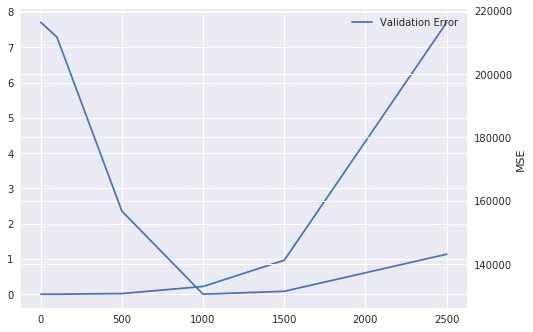

In [95]:
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
plt.style.use("seaborn")
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label="Training Error")
ax1 = ax.twinx()
ax1.plot(train_sizes, validation_scores_mean, label="Validation Error")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.legend()

In [5]:
X = big_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state = 50)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train.values.astype(float), y_train)

y_pred = xgb_model.predict(X_test.values.astype(float))
y_train_pred = xgb_model.predict(X_train.values.astype(float))
print(metrics.r2_score(y_train, y_train_pred))
print(metrics.r2_score(y_test, y_pred))

print(metrics.mean_squared_error(y_train, y_train_pred))
print(metrics.mean_squared_error(y_test, y_pred))

print(metrics.mean_absolute_error(y_train, y_train_pred))
print(metrics.mean_absolute_error(y_test, y_pred))

fi_xgb = pd.DataFrame({'feature': big_data.columns,
                   'importance': xgb_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
print(fi_xgb.iloc[:25, :])

0.9999989659033197
0.9651922064277402
0.3235871612850955
5179.693608014754
0.4146807615312768
25.36975920560995
           feature  importance
105        cases-1    0.756434
103        cases-3    0.082243
88     mobility-13    0.044629
3          Density    0.027741
81     mobility-20    0.015452
10      Population    0.007193
84     mobility-17    0.006619
83     mobility-18    0.005587
17     max_temp-21    0.005558
34      max_temp-4    0.005310
11      days_since    0.003896
85     mobility-16    0.003768
90     mobility-11    0.003342
28     max_temp-10    0.002943
98      mobility-3    0.002931
70   wind speed-10    0.002821
87     mobility-14    0.001620
30      max_temp-8    0.001530
71    wind speed-9    0.001435
4        Income_pc    0.001334
21     max_temp-17    0.001324
102        cases-4    0.001235
14   precipitation    0.001006
101        cases-5    0.000970
13        max_temp    0.000955


In [7]:
dtrain = xgb.DMatrix(X_train.values.astype(float), label=y_train)
dtest = xgb.DMatrix(X_test.values.astype(float), label=y_test)
params = {
    'max_depth': 10,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'eval_metric': 'mae'
}
num_boost_round = 999
xgb_model2 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)


[0]	Test-mae:111.39166
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:100.89665
[2]	Test-mae:91.69439
[3]	Test-mae:83.26609
[4]	Test-mae:75.96760
[5]	Test-mae:69.31424
[6]	Test-mae:63.46200
[7]	Test-mae:58.33143
[8]	Test-mae:53.68815
[9]	Test-mae:49.61673
[10]	Test-mae:46.07375
[11]	Test-mae:42.98417
[12]	Test-mae:40.38000
[13]	Test-mae:38.14841
[14]	Test-mae:36.18219
[15]	Test-mae:34.60948
[16]	Test-mae:33.14151
[17]	Test-mae:31.95091
[18]	Test-mae:30.90333
[19]	Test-mae:29.99169
[20]	Test-mae:29.15202
[21]	Test-mae:28.46179
[22]	Test-mae:27.98777
[23]	Test-mae:27.62144
[24]	Test-mae:27.29489
[25]	Test-mae:26.88334
[26]	Test-mae:26.50535
[27]	Test-mae:26.17326
[28]	Test-mae:25.87003
[29]	Test-mae:25.63034
[30]	Test-mae:25.40519
[31]	Test-mae:25.23285
[32]	Test-mae:25.08637
[33]	Test-mae:24.95252
[34]	Test-mae:24.83356
[35]	Test-mae:24.75769
[36]	Test-mae:24.66379
[37]	Test-mae:24.61220
[38]	Test-mae:24.57855
[39]	Test-mae:24.53985
[40]	Test-mae:24.50699
[41]	Test

In [140]:
xgb_cv = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={"mae"},
    early_stopping_rounds=10
)
xgb_cv

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,132.306458,4.522455,132.391861,18.612326
1,119.868501,4.065258,120.095344,16.983287
2,108.650704,3.674108,109.407079,15.203836
3,98.500307,3.310442,99.844885,13.839583
4,89.344429,2.982569,91.186319,12.403415
...,...,...,...,...
209,0.189293,0.014206,23.902295,3.629447
210,0.186838,0.013536,23.902308,3.629525
211,0.184115,0.013210,23.902124,3.629620
212,0.181668,0.012951,23.901714,3.629710


In [ ]:
y_pred_xgb3 = xgb_model2.predict(dtest)
y_pred_xgb3_train = xgb_model2.predict(dtrain)
print(metrics.r2_score(y_test, y_pred_xgb2))
print(metrics.r2_score(y_train, y_pred_xgb2_train))

print(metrics.mean_squared_error(y_test, y_pred_xgb2))
print(metrics.mean_squared_error(y_train, y_pred_xgb2_train))

print(metrics.mean_absolute_error(y_test, y_pred_xgb2))
print(metrics.mean_absolute_error(y_train, y_pred_xgb2_train))

xgb2fiscores = xgb_model2.get_score(importance_type='weight')
total = sum(xgb2fiscores.values())
xgb2fi = sorted([x/total for x in xgb2fiscores.values()])

fi_xgb2 = pd.DataFrame({'feature': big_data.columns,
                   'importance': xgb2fi}).\
                    sort_values('importance', ascending = False)
print(fi_xgb2.iloc[:25, :])

In [158]:
county_accuracy = pd.DataFrame(columns=["fips", "random_forest1", "random_forest2", "xgboost1", "xgboost2", "len"])
temp = []
for key, df in data.items():
    datum = df.copy()
    datum_labels = datum.pop("delta")
    dtest2 = xgb.DMatrix(datum.values.astype(float), label=datum_labels)
    m_err= metrics.r2_score(np.array(datum_labels).astype("float"), model.predict(datum))
    o_err= metrics.r2_score(np.array(datum_labels).astype("float"), opt1.predict(datum))
    xgb_err = metrics.r2_score(np.array(datum_labels).astype("float"), xgb_model.predict(datum.values.astype(float)))
    xgb2_err = metrics.r2_score(np.array(datum_labels).astype("float"), xgb_model2.predict(dtest2))


    temp = [key, m_err, o_err, xgb_err, xgb2_err, len(df)]
    county_accuracy = county_accuracy.append(pd.Series(temp, index=county_accuracy.columns), ignore_index=True)
county_accuracy

,fips,random_forest1,random_forest2,xgboost1,xgboost2,len
0,1073.0,-1.166593,-2.865978,-1.448372,0.625163,28
1,6001.0,-0.011534,-0.123655,0.784490,0.660997,36
2,6013.0,-0.725730,-2.498487,0.522719,0.608098,39
3,6029.0,-2.701385,-3.768038,-7.164759,-5.660947,11
4,6037.0,0.835159,0.791508,0.774767,0.615746,45
...,...,...,...,...,...,...
99,53063.0,-1.127833,-3.974968,-0.166986,0.538643,30
100,53073.0,-1.049739,-6.692103,-0.495318,0.662863,30
101,53077.0,0.585587,0.654805,0.635556,0.655571,30
102,55025.0,-2.251392,-8.960665,-0.776232,0.621387,34


In [111]:
sorted(county_accuracy)

['fips', 'len', 'random_forest1', 'random_forest2', 'xgboost1', 'xgboost2']

,fips,random_forest1,random_forest2,xgboost1,xgboost2,len
0,1073.0,-1.166593,-2.865978,-1.448372,0.625163,28
3,6029.0,-2.701385,-3.768038,-7.164759,-5.660947,11
75,36067.0,-4.069258,-6.256420,-1.472580,-2.128009,30


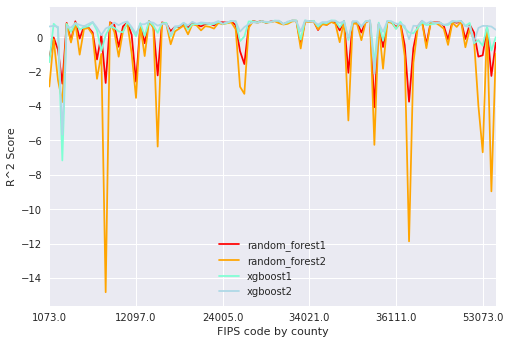

In [170]:
ax = county_accuracy.plot(x="fips", y=["random_forest1", "random_forest2", "xgboost1", "xgboost2"], color=["red", "orange", "aquamarine", "lightblue"])
ax.set_xlabel("FIPS code by county")
ax.set_ylabel("R^2 Score")
# ax.scatter(county_accuracy["len"], county_accuracy["model_err"])
# ax.scatter(county_accuracy["len"], county_accuracy["opt_err"])
# ax.scatter(county_accuracy["len"], county_accuracy["model_err"], color="orange")
county_accuracy[county_accuracy["xgboost1"] < -1]

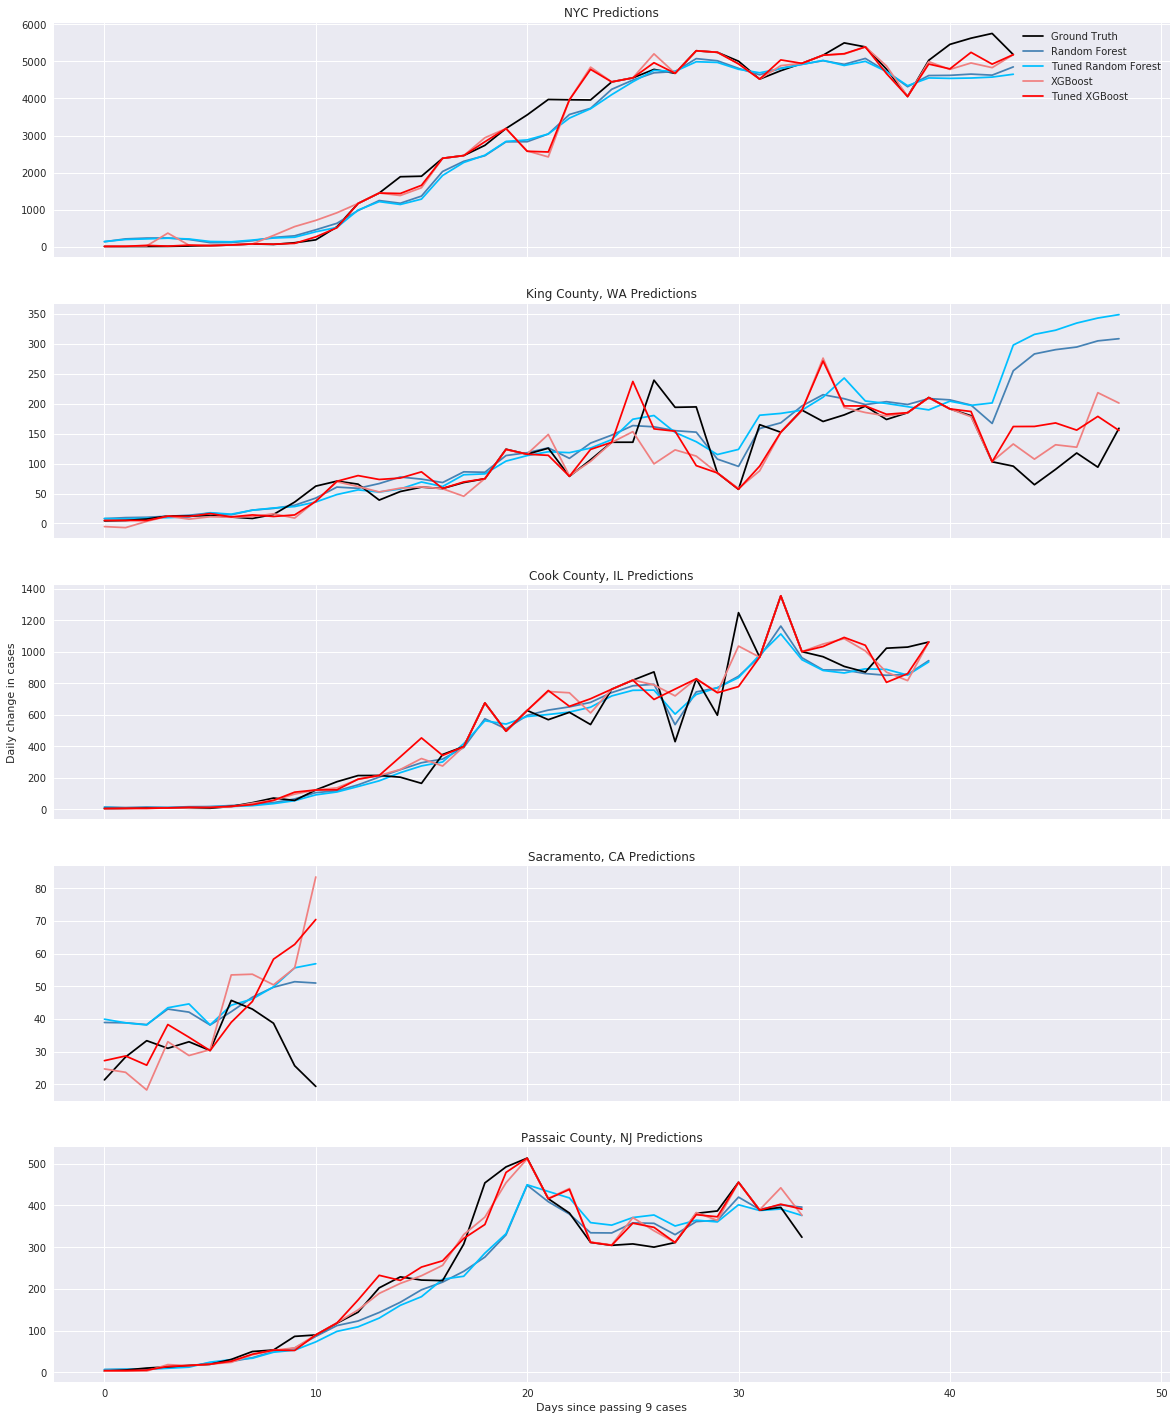

In [171]:
# from sklearn.metrics import mean_squared_error
# print(model.score(test, test_labels))
# print(opt1.score(test, test_labels))
# print(mean_squared_error(test_labels, rf_predictions_test))
# print(mean_squared_error(test_labels, opt1_predictions_test))

nyc_data = data["36061.0"].copy()
wash = data["53033.0"].copy()
il = data["17031.0"].copy()
sac = data["6029.0"].copy()
last = data["34031.0"].copy()

nyc_labels = nyc_data.pop("delta")
wash_labels = wash.pop("delta")
il_labels = il.pop("delta")
sac_labels = sac.pop("delta")
last_labels = last.pop("delta")

nyc_predictions = model.predict(nyc_data)
nyc1_predictions = opt1.predict(nyc_data)
nyc_xgb = xgb_model.predict(nyc_data.values.astype(float))
nyc_xgb2 = xgb_model2.predict(xgb.DMatrix(nyc_data.values.astype(float), label=nyc_labels))

wash_predictions = model.predict(wash)
wash1_predictions = opt1.predict(wash)
wash_xgb = xgb_model.predict(wash.values.astype(float))
wash_xgb2 = xgb_model2.predict(xgb.DMatrix(wash.values.astype(float), label=wash_labels))

il_predictions = model.predict(il)
il1_predictions = opt1.predict(il)
il_xgb = xgb_model.predict(il.values.astype(float))
il_xgb2 = xgb_model2.predict(xgb.DMatrix(il.values.astype(float), label=il_labels))

sac_predictions = model.predict(sac)
sac1_predictions = opt1.predict(sac)
sac_xgb = xgb_model.predict(sac.values.astype(float))
sac_xgb2 = xgb_model2.predict(xgb.DMatrix(sac.values.astype(float), label=sac_labels))

last_predictions = model.predict(last)
last1_predictions = opt1.predict(last)
last_xgb = xgb_model.predict(last.values.astype(float))
last_xgb2 = xgb_model2.predict(xgb.DMatrix(last.values.astype(float), label=last_labels))


fig, ax = plt.subplots(5, figsize=(20, 25), sharex = True)
ax[0].plot(nyc_data["days_since"], nyc_labels, color="black")
ax[0].plot(nyc_data["days_since"], nyc_predictions, color="steelblue")
ax[0].plot(nyc_data["days_since"], nyc1_predictions, color ="deepskyblue")
ax[0].plot(nyc_data["days_since"], nyc_xgb, color="lightcoral")
ax[0].plot(nyc_data["days_since"], nyc_xgb2, color="red")
ax[0].set_title("NYC Predictions")

ax[1].plot(wash["days_since"], wash_predictions, color="steelblue")
ax[1].plot(wash["days_since"], wash1_predictions, color="deepskyblue")
ax[1].plot(wash["days_since"], wash_labels, color="black")
ax[1].plot(wash["days_since"], wash_xgb, color="lightcoral")
ax[1].plot(wash["days_since"], wash_xgb2, color="red")
ax[1].set_title("King County, WA Predictions")

ax[2].plot(il["days_since"], il_predictions, color="steelblue")
ax[2].plot(il["days_since"], il1_predictions, color="deepskyblue")
ax[2].plot(il["days_since"], il_labels, color="black")
ax[2].plot(il["days_since"], il_xgb, color="lightcoral")
ax[2].plot(il["days_since"], il_xgb2, color="red")
ax[2].set_title("Cook County, IL Predictions")
ax[2].set_ylabel("Daily change in cases")

ax[3].plot(sac["days_since"], sac_predictions, color="steelblue")
ax[3].plot(sac["days_since"], sac1_predictions, color="deepskyblue")
ax[3].plot(sac["days_since"], sac_labels, color="black")
ax[3].plot(sac["days_since"], sac_xgb, color="lightcoral")
ax[3].plot(sac["days_since"], sac_xgb2, color="red")
ax[3].set_title("Sacramento, CA Predictions")

ax[4].plot(last["days_since"], last_predictions, color="steelblue")
ax[4].plot(last["days_since"], last1_predictions, color="deepskyblue")
ax[4].plot(last["days_since"], last_labels, color="black")
ax[4].plot(last["days_since"], last_xgb, color="lightcoral")
ax[4].plot(last["days_since"], last_xgb2, color="red")
ax[4].set_title("Passaic County, NJ Predictions")
ax[4].set_xlabel("Days since passing 9 cases")

ax[0].legend(["Ground Truth", "Random Forest", "Tuned Random Forest", "XGBoost", "Tuned XGBoost"])
plt.savefig("locations0.png")

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

y = labels.reshape(-1, 1)
X = big_data

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state = 50)

svr = SVR(kernel="rbf")
svr.fit(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

X = big_data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state = 50)

regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)
best_n_estimators
best_regressor = GradientBoostingRegressor(
    max_depth = 2,
    n_estimators = best_n_estimators,
    learning_rate = 1.0
)
best_regressor.fit(X_train, y_train)
y_pred = best_regressor.predict(X_test)
print(r2_score(y_test, y_pred))

0.8412689599099984


Text(0.5, 1.0, 'King County, WA Predictions')

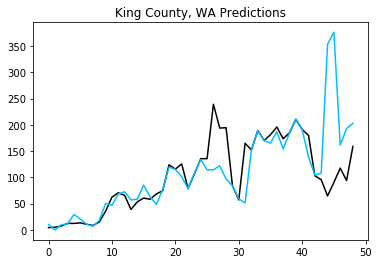

In [60]:
wash = data["53033.0"].copy()
wash_labels = wash.pop("delta")
wash_pred = xgb_model.predict(wash.values.astype(float))

fig, ax = plt.subplots()
ax.plot(wash["days_since"], wash_labels, color="black")
ax.plot(wash["days_since"], wash_pred, color ="deepskyblue")
ax.set_title("King County, WA Predictions")

In [30]:
map_df

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,isin
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",False
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",False
2,Stevens,Washington,53,065,53065,"POLYGON ((-117.43883 48.04412, -117.54219 48.0...",False
3,Okanogan,Washington,53,047,53047,"POLYGON ((-118.97209 47.93915, -118.97406 47.9...",False
4,Pend Oreille,Washington,53,051,53051,"POLYGON ((-117.43858 48.99992, -117.03205 48.9...",False
...,...,...,...,...,...,...,...
3136,Skagway-Hoonah-Angoon,Alaska,02,232,02232,"MULTIPOLYGON (((-137.80952 58.71648, -137.4674...",False
3137,Yukon-Koyukuk,Alaska,02,290,02290,"POLYGON ((-161.04770 62.20469, -160.99428 62.8...",False
3138,Southeast Fairbanks,Alaska,02,240,02240,"POLYGON ((-146.96382 63.46070, -146.95735 64.2...",False
3139,Denali,Alaska,02,068,02068,"POLYGON ((-152.98947 62.74900, -152.48773 63.1...",False


Text(156.25, 0.5, 'Latitude')

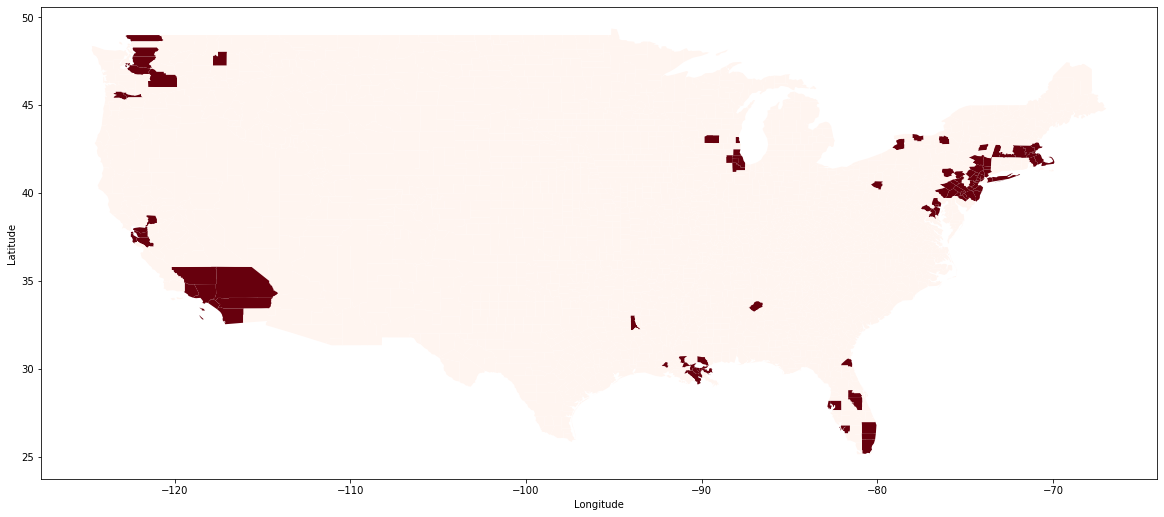

In [43]:
import geopandas as gpd
map_df = gpd.read_file("map/UScounties.shp")
counties = []
for key in data.keys():
    counties.append(str(int(key[:-2])).zfill(5))
map_df = map_df[map_df["STATE_NAME"] != "Alaska"]
map_df = map_df[map_df["STATE_NAME"] != "Hawaii"]
map_df["isin"] = map_df["FIPS"].isin(counties)
ax = map_df.plot(figsize=(20, 20), column="isin", cmap="Reds")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

In [145]:
big_data_delta = labels.copy()
big_data_delta

array([ 6.66666667,  6.66666667,  5.66666667, ..., 72.66666667,
       65.        , 67.66666667])